# Imports

In [109]:
import tensorflow as tf
import keras, keras.layers as L, keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from keras.models import save_model
import keras
from keras.datasets import cifar10, fashion_mnist
from keras.models import load_model
from keras.callbacks import TensorBoard

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import UpSampling2D, Reshape, Dense,Activation, Flatten, Dropout, BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, InputLayer
from keras import regularizers
from keras.callbacks import LearningRateScheduler

%matplotlib inline

# Architecture Variables

In [110]:
bit_size = 32
architecture = '1024'
autoencoder_id='07'
model_path = F'fashion-models/bitsize{bit_size}/{architecture}architecture/'

# Load Data

In [111]:
class ModelSaveCallback(keras.callbacks.Callback):

    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))


# !!! remember to clear session/graph if you rebuild your graph to avoid out-of-memory errors !!!
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)

In [112]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [113]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (60000, 28, 28) (60000,)
Test samples: (10000, 28, 28) (10000,)


In [114]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

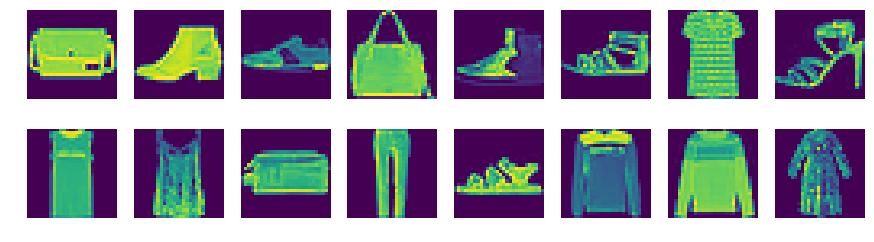

In [115]:

# show random images from train
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
#         ax.set_title(cifar10_classes[y_train[random_index, 0]])

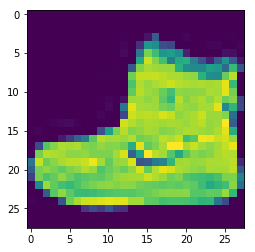

In [116]:
plt.imshow(x_train[0])

In [117]:
x_train = x_train.reshape([-1, 28, 28, 1])
x_test = x_test.reshape([-1, 28, 28, 1])

IMG_SHAPE = x_train.shape[1:]

# center images
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Architecture

In [292]:
def build_encoder(img_shape, code_size):
    weight_decay = 1e-4
    
    # encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    
    encoder.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
#     encoder.add(BatchNormalization())
    
#     encoder.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
#     encoder.add(BatchNormalization())
    
    
    encoder.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    
    encoder.add(Conv2D(filters=64,kernel_size=(3, 3),activation='relu',padding='same'))
#     encoder.add(BatchNormalization())
    
#     encoder.add(Conv2D(filters=64,kernel_size=(3, 3),activation='relu',padding='same'))
#     encoder.add(BatchNormalization())
    
    
    encoder.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    encoder.add(Conv2D(filters=128,kernel_size=(3, 3),activation='relu',padding='same'))
#     encoder.add(BatchNormalization())
    
#     encoder.add(Conv2D(filters=128,kernel_size=(3, 3),activation='relu',padding='same'))
#     encoder.add(BatchNormalization())
    
    encoder.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    

    
    encoder.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
#     encoder.add(BatchNormalization())
    
    encoder.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
#     encoder.add(BatchNormalization())
    
    encoder.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    encoder.add(Flatten())                  #flatten image to vector
    
    encoder.add(Dense(1024))
#     encoder.add(Dropout(0.1))
    encoder.add(Dense(512))
    
#     encoder.add(Dense(256))
    
#     encoder.add(Dense(128))
    
#     encoder.add(Dense(64))
    
    encoder.add(Dense(code_size))
    
    return encoder


def build_decoder(img_shape, code_size):
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    
#     decoder.add(Dense(64))
    
#     decoder.add(Dense(128))
    
#     decoder.add(Dense(256))
    
    decoder.add(Dense(512))
    
    decoder.add(Dense(1024))
    
    decoder.add(Reshape((2,2,256)))
    
    decoder.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
#     decoder.add(BatchNormalization())
    
#     decoder.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
#     decoder.add(BatchNormalization())
    
    decoder.add(UpSampling2D((2,2)))
    
    decoder.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
#     decoder.add(BatchNormalization())
    
#     decoder.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
#     decoder.add(BatchNormalization())
    
    decoder.add(UpSampling2D((2,2)))
    
    decoder.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
#     decoder.add(BatchNormalization())
    
#     decoder.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
#     decoder.add(BatchNormalization())
    
    decoder.add(UpSampling2D((2,2)))
    
    decoder.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
#     decoder.add(BatchNormalization())
    
#     decoder.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
#     decoder.add(BatchNormalization())
    
    decoder.add(UpSampling2D((2,2)))
    
    decoder.add(Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same'))
    
    return decoder

In [293]:
# def build_encoder(img_shape, code_size):
#     weight_decay = 1e-4
    
#     # encoder
#     encoder = Sequential()
#     encoder.add(InputLayer(img_shape))
    
#     encoder.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
# #     encoder.add(BatchNormalization())
    
# #     encoder.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
# #     encoder.add(BatchNormalization())
    
    
#     encoder.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    
# #     encoder.add(Conv2D(filters=64,kernel_size=(3, 3),activation='relu',padding='same'))
# #     encoder.add(BatchNormalization())
    
#     encoder.add(Conv2D(filters=64,kernel_size=(3, 3),activation='relu',padding='same'))
# #     encoder.add(BatchNormalization())
    
    
#     encoder.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
# #     encoder.add(Conv2D(filters=128,kernel_size=(3, 3),activation='relu',padding='same'))
# #     encoder.add(BatchNormalization())
    
#     encoder.add(Conv2D(filters=128,kernel_size=(3, 3),activation='relu',padding='same'))
# #     encoder.add(BatchNormalization())
    
#     encoder.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    

    
# #     encoder.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
# #     encoder.add(BatchNormalization())
    
#     encoder.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
# #     encoder.add(BatchNormalization())
    
#     encoder.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
#     encoder.add(Flatten())                  #flatten image to vector
    
# #     encoder.add(Dense(1024, activation='relu'))
# #     encoder.add(Dropout(0.1))
# #     encoder.add(Dense(1024, activation='relu'))
    
#     encoder.add(Dense(code_size))
    
#     return encoder


# def build_decoder(img_shape, code_size):
#     decoder = Sequential()
#     decoder.add(InputLayer((code_size,)))
    
# #     decoder.add(Dense(1024, activation='relu'))
    
#     decoder.add(Dense(1024))
    
#     decoder.add(Reshape((2,2,256)))
    
# #     decoder.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
# #     decoder.add(BatchNormalization())
    
#     decoder.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
# #     decoder.add(BatchNormalization())
    
#     decoder.add(UpSampling2D((2,2)))
    
# #     decoder.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
# #     decoder.add(BatchNormalization())
    
#     decoder.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
# #     decoder.add(BatchNormalization())
    
#     decoder.add(UpSampling2D((2,2)))
    
# #     decoder.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
# #     decoder.add(BatchNormalization())
    
#     decoder.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
# #     decoder.add(BatchNormalization())
    
#     decoder.add(UpSampling2D((2,2)))
    
#     decoder.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
# #     decoder.add(BatchNormalization())
    
# #     decoder.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
# #     decoder.add(BatchNormalization())
    
#     decoder.add(UpSampling2D((2,2)))
    
#     decoder.add(Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same'))
    
#     return decoder

In [294]:
# def build_deep_autoencoder(img_shape, code_size):
#     H,W,C = img_shape
    
#     # encoder
#     encoder = keras.models.Sequential()
#     encoder.add(L.InputLayer(img_shape))
    
#     encoder.add(L.Conv2D(filters=32, kernel_size=(3, 3), activation='elu', padding='same'))
#     encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
# #     encoder.add(L.BatchNormalization())
    
#     encoder.add(L.Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding='same'))
#     encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
# #     encoder.add(L.BatchNormalization())
    
#     encoder.add(L.Conv2D(filters=128, kernel_size=(3, 3), activation='elu', padding='same'))
#     encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
# #     encoder.add(L.BatchNormalization())
    
# #     encoder.add(L.Conv2D(filters=256, kernel_size=(3, 3), activation='elu', padding='same'))
# #     encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
# #     encoder.add(L.BatchNormalization())
    
#     encoder.add(L.Flatten())                  #flatten image to vector
    
#     encoder.add(L.Dense(2048, activation='elu'))
#     encoder.add(L.Dense(2048, activation='elu'))
# #     encoder.add(L.Dense(1024, activation='elu'))

# #     encoder.add(L.Dropout(rate=0.2))
# #     encoder.add(L.BatchNormalization())
    
# #     encoder.add(L.Dense(512, activation='elu'))
# #     encoder.add(L.Dropout(rate=0.2))
# #     encoder.add(L.BatchNormalization())

# #     encoder.add(L.Dense(256, activation='elu'))
    
# #     encoder.add(L.Dense(128, activation='elu'))
    
#     encoder.add(L.Dense(code_size)) 

#     # decoder
#     decoder = keras.models.Sequential()
#     decoder.add(L.InputLayer((code_size,)))
    
#     decoder.add(L.Dense(4*4*128))  #actual decoder, height*width*3 units
    
# #     decoder.add(L.Dense(128, activation='elu'))
# #     decoder.add(L.Dropout(rate=0.2))
# #     decoder.add(L.BatchNormalization())
    
# #     decoder.add(L.Dense(256, activation='elu'))
# #     decoder.add(L.Dropout(rate=0.2))
# #     decoder.add(L.BatchNormalization())
# #     decoder.add(L.Dense(512, activation='elu'))
    
#     decoder.add(L.Dense(2048, activation='elu'))
#     decoder.add(L.Dense(2048, activation='elu'))
# #     decoder.add(L.Dense(1024, activation='elu'))
    
#     decoder.add(L.Reshape((4,4,128)))
    
#     decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
# #     decoder.add(L.BatchNormalization())
    
#     decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
# #     decoder.add(L.BatchNormalization())
    
#     decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
# #     decoder.add(L.BatchNormalization())
    
# #     decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
    
#     return encoder, decoder


In [295]:
reset_tf_session()

In [296]:
encoder = build_encoder(IMG_SHAPE, code_size=bit_size)
decoder = build_decoder(IMG_SHAPE, code_size=bit_size)
encoder.summary()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
__________

In [297]:
def lr_scheduler(epoch):
    lrate = 0.001
    
    if epoch > 15:
        lrate = 0.0005
    if epoch > 20:
        lrate = 0.0003
    
    return lrate

In [298]:
optimizer = keras.optimizers.adam(decay=1e-6)

In [299]:
log_path = F'fashion-logs/autoencoder-{bit_size}-{architecture}-{autoencoder_id}'
tensorboard = TensorBoard(log_dir=log_path)

In [300]:
inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer=optimizer, loss='mse')

# Training

In [ ]:
autoencoder.fit(x=x_train, y=x_train, epochs=200, batch_size=500, shuffle=True,
                validation_data=[x_test, x_test],
                callbacks=[tensorboard],
                verbose=1,
                initial_epoch= 0)

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 5s 90us/step - loss: 0.0621 - val_loss: 0.0302
Epoch 2/200
60000/60000 [==============================] - 5s 87us/step - loss: 0.0260 - val_loss: 0.0225
Epoch 3/200
60000/60000 [==============================] - 5s 86us/step - loss: 0.0216 - val_loss: 0.0200
Epoch 4/200
60000/60000 [==============================] - 5s 86us/step - loss: 0.0189 - val_loss: 0.0178
Epoch 5/200
15500/60000 [======>.......................] - ETA: 3s - loss: 0.0180

In [ ]:
autoencoder.save(F'{model_path}autoencoder{autoencoder_id}.h5')

In [21]:
encoder.save(F'{model_path}encoder{autoencoder_id}.h5')

In [22]:
decoder.save(F'{model_path}decoder{autoencoder_id}.h5')

In [23]:
autoencoder = load_model(F'{model_path}autoencoder{autoencoder_id}.h5')
encoder = load_model(F'{model_path}encoder{autoencoder_id}.h5')
decoder = load_model(F'{model_path}decoder{autoencoder_id}.h5')

/home/nicoroble/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [24]:
code = encoder.predict(x_test[0][None])

In [25]:
reco = decoder.predict(code)[0].reshape(28,28)

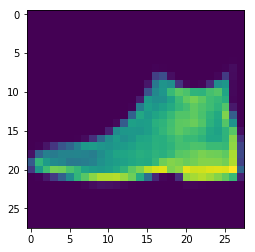

In [26]:
plt.imshow(reco)

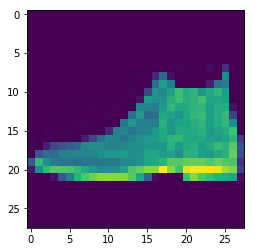

In [27]:
plt.imshow(x_test[0].reshape(28,28))